In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage import color
import os
import cv2


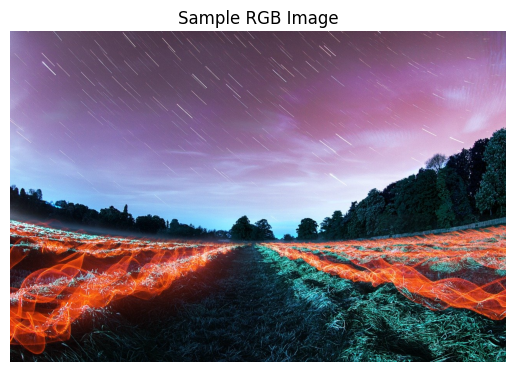

In [2]:


raw_img_path = os.path.join(os.getcwd(), 'data', 'raw_img.tiff')

img = cv2.imread(raw_img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.title('Sample RGB Image')
plt.axis('off')
plt.show()

1. **Matrix Definition**:
   - `mat` is a 3x3 matrix defined with specific coefficients that transform RGB values to YCbCr values. These coefficients are based on the color transformation standards used in image processing.
     - The first row `[0.299, 0.587, 0.114]` transforms RGB values to the luminance component (Y). This row represents how much each color (Red, Green, Blue) contributes to the brightness of the color.
     - The second row `[-0.168736, -0.331264, 0.5]` is used to calculate the blue-difference chroma component (Cb).
     - The third row `[0.5, -0.418688, -0.081312]` calculates the red-difference chroma component (Cr).

2. **Matrix Multiplication**:
   - `img @ mat.T`: The `@` operator performs matrix multiplication between the image data `img` and the transpose of the matrix `mat` (`mat.T`). Here, `img` is expected to be an array where each pixel is represented by RGB values. The matrix multiplication applies the coefficients to each RGB pixel to convert it to YCbCr.
   - Transposing `mat` with `.T` changes its shape to align properly for matrix multiplication with the RGB image data. Each color channel of the image is multiplied by the corresponding weights to create the Y, Cb, and Cr components.

3. **Addition of Constants**:
   - `+ [0, 128, 128]`: This step adjusts the Cb and Cr components by adding 128 to each. The addition of 128 is a standard practice in image processing to center the chroma values around 128, making them unsigned with a range from 0 to 255. The Y component does not need any adjustment and remains in the range 0 to 255.

4. **Rounding and Type Conversion**:
   - `np.round(ycbcr)`: Rounds the values to the nearest integers. This step is important as the YCbCr values obtained from the matrix multiplication can be floating point numbers.
   - `.astype(np.uint8)`: Converts the rounded values to 8-bit unsigned integers. This type conversion is crucial for image processing as images are typically represented in 8-bit integers per channel in most applications.

### Output
- The function returns the transformed image data in the YCbCr color space with each component (Y, Cb, Cr) properly scaled and adjusted.

This transformation is common in image processing, particularly before performing tasks like compression (as in JPEG), where working in YCbCr space is advantageous due to its ability to separate luminance data from color information, allowing more meaningful compression techniques to be applied.

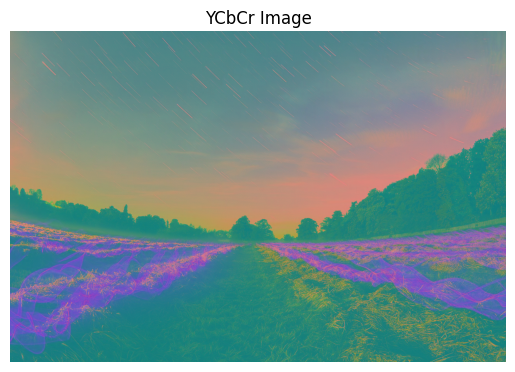

In [3]:
img_ycbcr = color.rgb2ycbcr(img)

plt.imshow(img_ycbcr.astype(np.uint8))
plt.title('YCbCr Image')
plt.axis('off')
plt.show()

In [4]:
def dct2(block):
    """2D DCT transform."""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def quantize(block, quantization_matrix):
    """Quantize the DCT coefficients."""
    return np.round(block / quantization_matrix) * quantization_matrix

def idct2(block):
    """2D inverse DCT transform."""
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def pad_image_to_8x(img):
    """Pad the image to ensure its dimensions are multiples of 8."""
    h, w = img.shape[:2]
    h_pad = (8 - h % 8) % 8
    w_pad = (8 - w % 8) % 8
    padded_img = np.pad(img, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0)
    return padded_img, h, w  # Return original height and width for cropping later

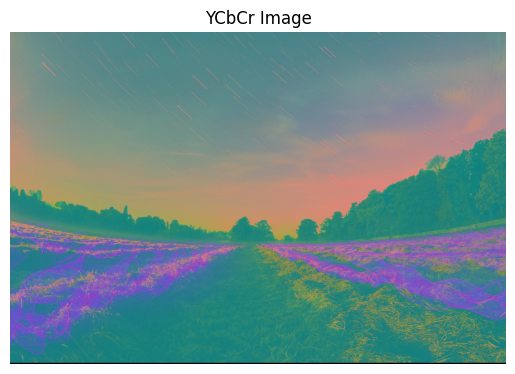

In [5]:
img_ycbcr, orig_height, orig_width = pad_image_to_8x(img_ycbcr)
plt.imshow(img_ycbcr.astype(np.uint8))
plt.title('YCbCr Image')
plt.axis('off')
plt.show()


In [6]:

quality_factor =  50

Q = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])
Q = Q * (quality_factor / 50) if quality_factor > 50 else Q * (50 / quality_factor)

height, width = img_ycbcr.shape[:2]
# Create an empty array for the compressed image
compressed = np.zeros_like(img_ycbcr)

# Process each 8x8 block
for i in range(0, height, 8):
    for j in range(0, width, 8):
        for k in range(3):  # For each channel (Y, Cb, Cr)
            block = img_ycbcr[i:i+8, j:j+8, k]
            dct_block = dct2(block)
            quantized = quantize(dct_block, Q)
            compressed[i:i+8, j:j+8, k] = idct2(quantized)

# Convert the compressed image back to RGB
compressed = compressed[:orig_height, :orig_width, :]
compressed = color.ycbcr2rgb(compressed)
compressed = compressed.clip(0, 1)

- **Input**: `image` - a 2D array representing one channel of the image, typically the luminance (Y) component.
- **Process**:
  - The image dimensions are assumed to be multiples of 8, which is standard in JPEG compression to ensure that the entire image can be divided into non-overlapping 8x8 blocks.
  - A loop iterates over each 8x8 block in the image.
  - `apply_dct` is called for each block to transform it into the frequency domain.
  - The transformed blocks replace their corresponding positions in a new image array `transformed`.
- **Output**: The entire image transformed into the frequency domain, with each block containing frequency components instead of spatial pixel values.

### Application and Importance in JPEG Compression
- **Frequency Separation**: After applying DCT, most of the visually significant information (like edges and contrasts) tends to be concentrated in the lower frequency components. These components are less likely to be discarded during the quantization step that follows.
- **Compression**: Because high-frequency components (representing rapid changes in pixel values) are often less important, they can be quantized more coarsely or even discarded without significantly degrading the perceived image quality. This results in substantial data compression.

The use of DCT is central to JPEG's efficiency, allowing it to achieve high compression ratios while maintaining good visual quality by leveraging human visual sensitivity characteristics, which are more attuned to broad patterns and colors than to fine detail.

### DCT Concept

Imagine you have a digital photo on your computer, and it's made up of lots of tiny squares called pixels. Each pixel has a color and brightness value. Now, if we wanted to save space on our computer by making the photo file size smaller, we could use a technique called DCT.

Think of DCT as a clever way of repacking the photo. It looks at each small block of pixels (like a tiny section of the photo), and instead of storing information about every single pixel, it figures out patterns in the brightness across these pixels. It then saves a simpler description of these patterns.

Here’s a more relatable analogy: If you have a smoothie recipe that calls for a cup of blueberries, instead of listing "add one blueberry, add another blueberry, …" up to a cup, you just say, "add one cup of blueberries." DCT does something similar; it combines the similar information in an area of the photo to make the instruction (or the data needed) simpler.

So, by using DCT, your computer can describe the photo using less information than before, which saves space. And the cool thing is, when you look at the photo again, it still looks pretty much the same, even though it's technically using less data to store the picture! This is how JPEG images work to keep your photos looking good without taking up too much space on your device.

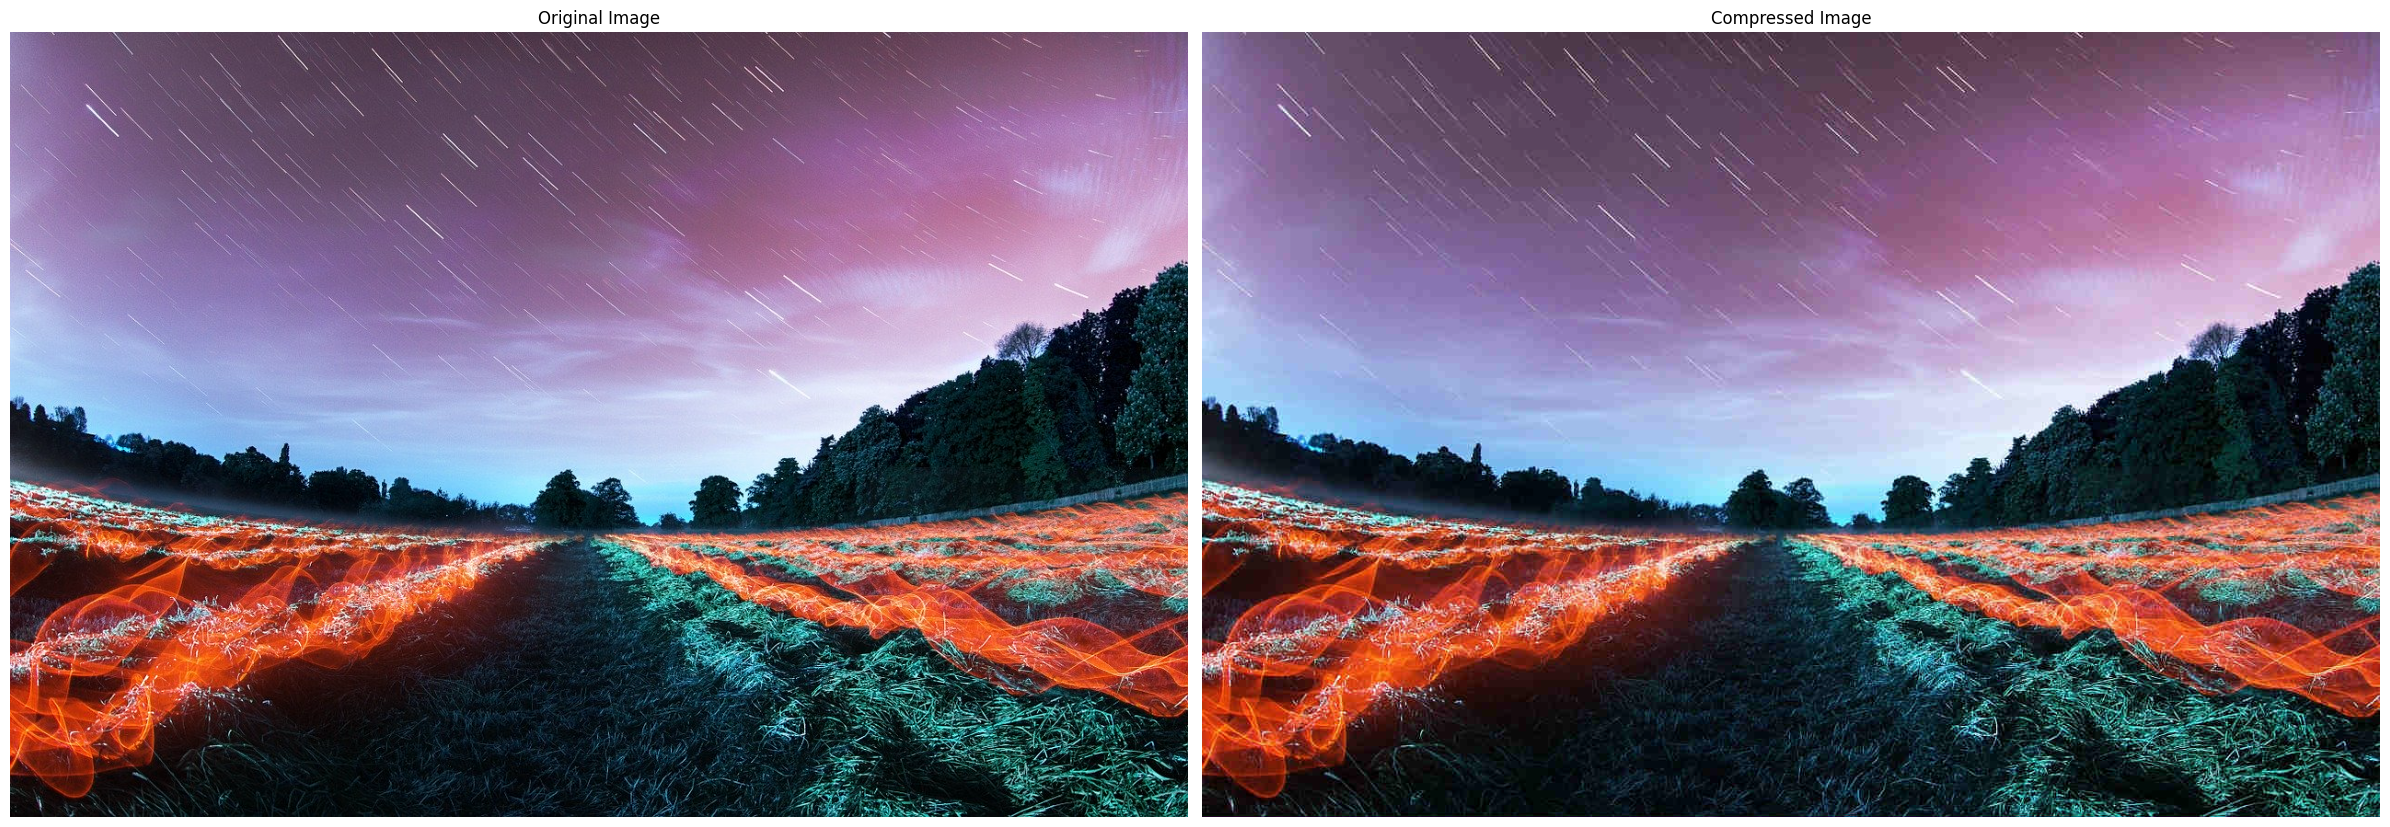

PSNR (Quality 100): 25.81 dB


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))
axes = axes.ravel()

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(compressed)
axes[1].set_title(f'Compressed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

compressed = (compressed * 255)
mse = np.mean((img - compressed) ** 2)
psnr = 20 * np.log10(255 / np.sqrt(mse))
print(f"PSNR (Quality {quality_factor}): {psnr:.2f} dB")

In [8]:
# save image
compressed_img_path = os.path.join(os.getcwd(), 'data', 'compressed_img_from_tiff.jpg')
cv2.imwrite(compressed_img_path, compressed)

True